#Carga del dataset

In [ ]:
import pickle
import random
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

FILE_PATH_TRAINING = '/content/drive/MyDrive/Tesis/dataset/dataset_256_256_CBIS-DDSM_dict-training.pkl'
FILE_PATH_TEST = '/content/drive/MyDrive/Tesis/dataset/dataset_256_256_CBIS-DDSM_dict-test.pkl'

def getMammographyDataset(file_path):

    with open(file_path, 'rb') as file:
        dataset = pickle.load(file)

    keys = list(dataset.keys())
    random.shuffle(keys)

    x_ray = np.array([dataset[key]['image_file_numpy'] for key in keys])
    y_roi = np.array([dataset[key]['roi_mask_file_numpy'] for key in keys])

    y_roi_train_bin = (y_roi > 0.5).astype(np.uint8)

    y_roi = y_roi_train_bin.astype(np.float32)

    return (x_ray, y_roi)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.model_selection import train_test_split

# Obtener el dataset TRAINING
(x_ray_train, y_roi_train) = getMammographyDataset(FILE_PATH_TRAINING)
(x_ray_test, y_roi_test) = getMammographyDataset(FILE_PATH_TEST)

# Divide entrenamiento en 80% train y 20% validación
x_ray_train, x_ray_val, y_roi_train, y_roi_val = train_test_split(
    x_ray_train, y_roi_train, test_size=0.2, random_state=42
)


# Verifica la forma de tus datos de entrada
print(x_ray_train.shape)
print(y_roi_train.shape)

# Verifica la forma de tus datos de prueba
print(x_ray_val.shape)
print(y_roi_val.shape)

# Verifica la forma de tus datos de validacón
print(x_ray_test.shape)
print(y_roi_test.shape)



(568, 256, 256, 1)
(568, 256, 256, 1)
(143, 256, 256, 1)
(143, 256, 256, 1)
(201, 256, 256, 1)
(201, 256, 256, 1)


(568, 256, 256, 1)


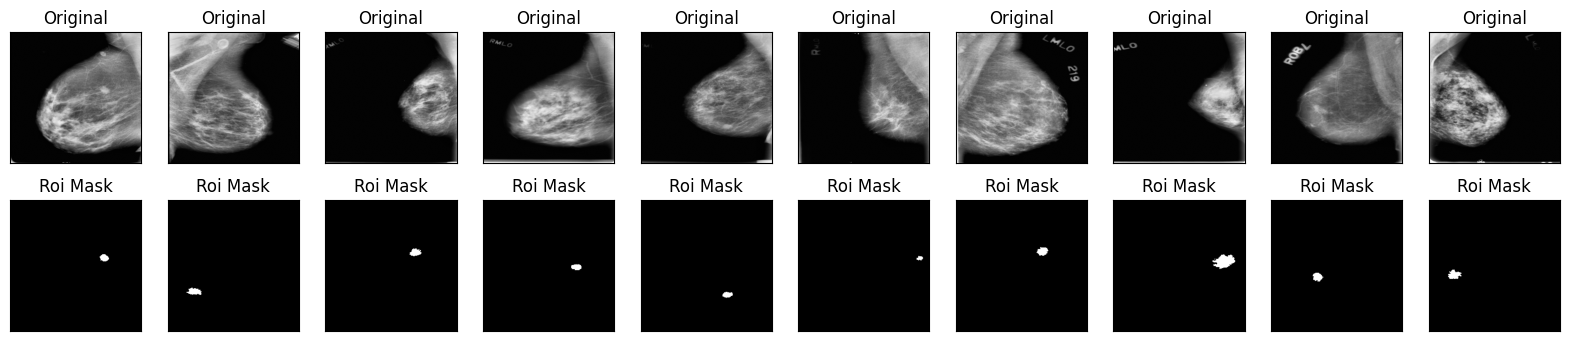

In [ ]:
import matplotlib.pyplot as plt
#(x_ray_train, y_roi_train), (x_ray_test, y_roi_test) = getMammographyDataset()
#Constantes para el tamaño de las imágenes
HEIGHT = 256
WIDTH = 256

print(x_ray_train.shape)

# Mostrar las imágenes originales y roi
n = 10  # Número de imágenes a mostrar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Muestra la imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_ray_val[i].reshape(HEIGHT, WIDTH), cmap="gray")
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Muestra la imagen reconstruida
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(y_roi_val[i].reshape(HEIGHT, WIDTH), cmap="gray")
    plt.title("Roi Mask")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
print(f"Total imágenes de entrenamiento: {len(x_ray_train)}")
print(f"Total imágenes de validación: {len(x_ray_val)}")
print(f"Total imágenes de prueba: {len(x_ray_test)}")
print(f"Total imágenes en el dataset: {len(x_ray_train) + len(x_ray_test) + len(x_ray_val)}")


Total imágenes de entrenamiento: 568
Total imágenes de validación: 143
Total imágenes de prueba: 201
Total imágenes en el dataset: 912


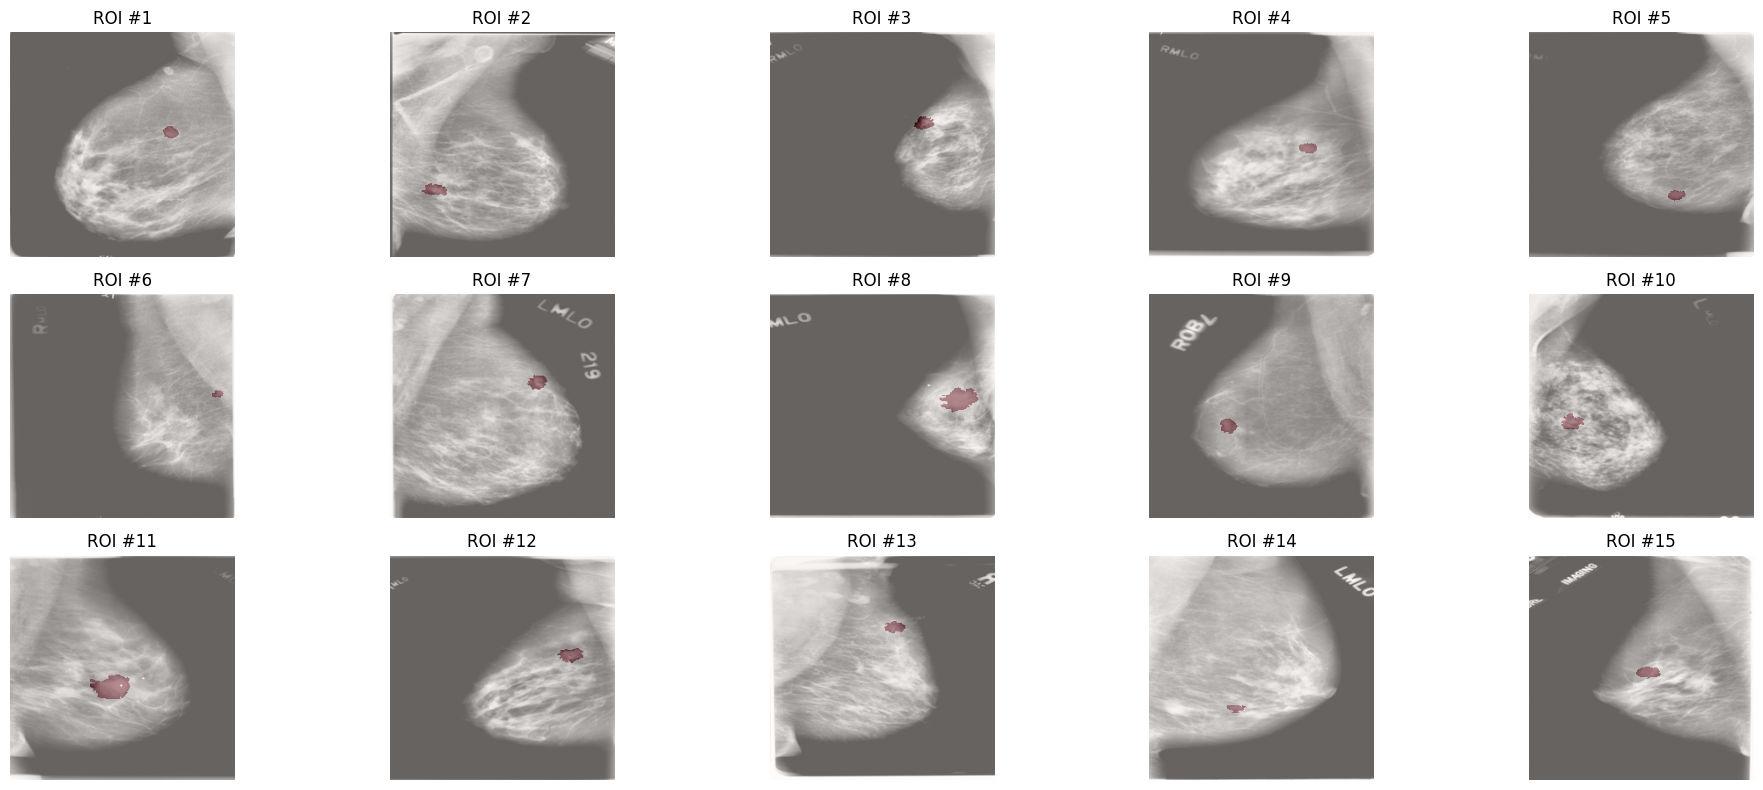

In [ ]:
import matplotlib.pyplot as plt

# Constantes
HEIGHT, WIDTH = 256, 256
n = 15  # Número de imágenes a mostrar

plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(3, 5, i + 1)
    base_img = x_ray_val[i].reshape(HEIGHT, WIDTH)
    roi_mask = y_roi_val[i].reshape(HEIGHT, WIDTH)

    # Mostrar imagen base
    plt.imshow(base_img, cmap='gray')

    # Superponer ROI en rojo con transparencia
    plt.imshow(roi_mask, cmap='Reds', alpha=0.4)

    plt.title(f'ROI #{i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np


def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [ ]:
import tensorflow as tf

# Dice Loss personalizada
def dice_loss_ember(y_true, y_pred, smooth=1.0):
    y_pred = tf.keras.backend.sigmoid(y_pred)  # Asegura valores entre 0 y 1
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return 1 - dice

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

#Modelo Unet ++

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import matplotlib.pyplot as plt
import numpy as np

def conv_block(x, filters, name):
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same', name=name+'_conv1')(x)
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same', name=name+'_conv2')(x)
    return x

def unet_plus_plus(input_shape=(256, 256, 1), num_classes=1):
    inputs = Input(shape=input_shape)

    # Encoder
    x00 = conv_block(inputs, 64, 'x00')
    x10 = layers.MaxPooling2D((2, 2))(x00)
    x10 = conv_block(x10, 128, 'x10')

    x20 = layers.MaxPooling2D((2, 2))(x10)
    x20 = conv_block(x20, 256, 'x20')

    x30 = layers.MaxPooling2D((2, 2))(x20)
    x30 = conv_block(x30, 512, 'x30')

    x40 = layers.MaxPooling2D((2, 2))(x30)
    x40 = conv_block(x40, 1024, 'x40')

    # Decoder
    x01 = conv_block(layers.Concatenate()([x00, layers.UpSampling2D((2, 2), interpolation='bilinear')(x10)]), 64, 'x01')
    x11 = conv_block(layers.Concatenate()([x10, layers.UpSampling2D((2, 2), interpolation='bilinear')(x20)]), 128, 'x11')
    x21 = conv_block(layers.Concatenate()([x20, layers.UpSampling2D((2, 2), interpolation='bilinear')(x30)]), 256, 'x21')
    x31 = conv_block(layers.Concatenate()([x30, layers.UpSampling2D((2, 2), interpolation='bilinear')(x40)]), 512, 'x31')

    x02 = conv_block(layers.Concatenate()([x00, x01, layers.UpSampling2D((2, 2), interpolation='bilinear')(x11)]), 64, 'x02')
    x12 = conv_block(layers.Concatenate()([x10, x11, layers.UpSampling2D((2, 2), interpolation='bilinear')(x21)]), 128, 'x12')
    x22 = conv_block(layers.Concatenate()([x20, x21, layers.UpSampling2D((2, 2), interpolation='bilinear')(x31)]), 256, 'x22')

    x03 = conv_block(layers.Concatenate()([x00, x01, x02, layers.UpSampling2D((2, 2), interpolation='bilinear')(x12)]), 64, 'x03')
    x13 = conv_block(layers.Concatenate()([x10, x11, x12, layers.UpSampling2D((2, 2), interpolation='bilinear')(x22)]), 128, 'x13')

    x04 = conv_block(layers.Concatenate()([x00, x01, x02, x03, layers.UpSampling2D((2, 2), interpolation='bilinear')(x13)]), 64, 'x04')

    output = layers.Conv2D(num_classes, (1, 1), activation='sigmoid', name='final_output')(x04)
    model = Model(inputs, output)
    return model


In [ ]:
import tensorflow as tf
from datetime import datetime
import pickle

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
MODEL_SAVE_PATH = f"/content/drive/MyDrive/Tesis/salidas/{timestamp}_unet++_autoencoder.keras"
HISTORY_SAVE_PATH = f"/content/drive/MyDrive/Tesis/salidas/{timestamp}_unet++_autoencoder_history.pkl"

model = unet_plus_plus()
metrics=[dice_coef, iou_coef]
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

history = model.fit(x_ray_train, y_roi_train, epochs=40, batch_size=20, validation_data=(x_ray_val, y_roi_val))

# GUARDAR MODELO
model.save(MODEL_SAVE_PATH)
print(f"✅ Modelo guardado en: {MODEL_SAVE_PATH}")

# GUARDAR HISTORIAL DE MÉTRICAS
with open(HISTORY_SAVE_PATH, "wb") as f:
    pickle.dump(history.history, f)
print(f"✅ Historial guardado en: {HISTORY_SAVE_PATH}")

Epoch 1/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - dice_coef: 0.0049 - iou_coef: 0.0025 - loss: 0.3691 - val_dice_coef: 0.0222 - val_iou_coef: 0.0112 - val_loss: 0.0271
Epoch 2/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 499ms/step - dice_coef: 0.0226 - iou_coef: 0.0114 - loss: 0.0285 - val_dice_coef: 0.0226 - val_iou_coef: 0.0114 - val_loss: 0.0230
Epoch 3/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 499ms/step - dice_coef: 0.0298 - iou_coef: 0.0151 - loss: 0.0241 - val_dice_coef: 0.0359 - val_iou_coef: 0.0183 - val_loss: 0.0212
Epoch 4/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 499ms/step - dice_coef: 0.0451 - iou_coef: 0.0231 - loss: 0.0247 - val_dice_coef: 0.0559 - val_iou_coef: 0.0288 - val_loss: 0.0210
Epoch 5/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 499ms/step - dice_coef: 0.0436 - iou_coef: 0.0223 - loss: 0.0243 - val_dice_coef: 0.0703 - val_iou_coef: 0.0365 - val_loss: 0.0197
Epoch 6/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 499ms/step - dice_coef: 0.0692 - iou_coef: 0.0359 - loss: 0.0218 - val_dice_coef: 0.0737 - val_

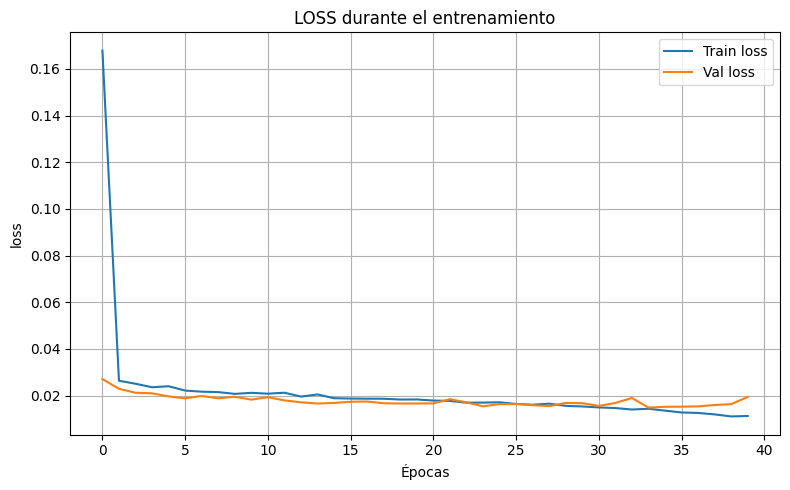

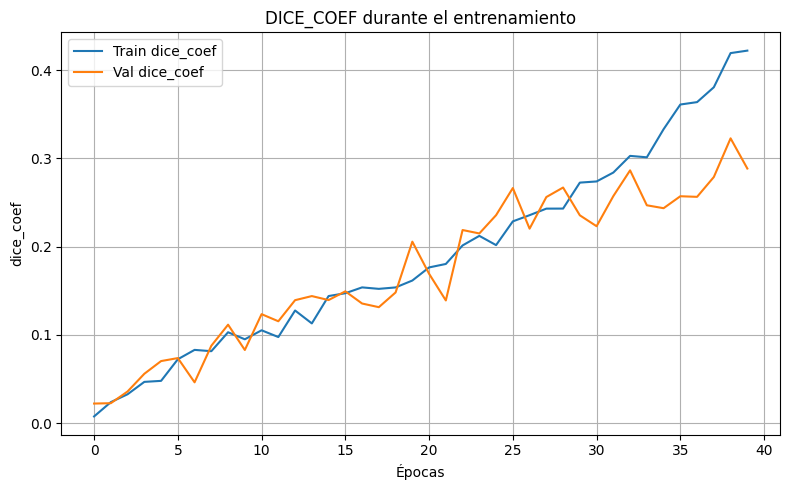

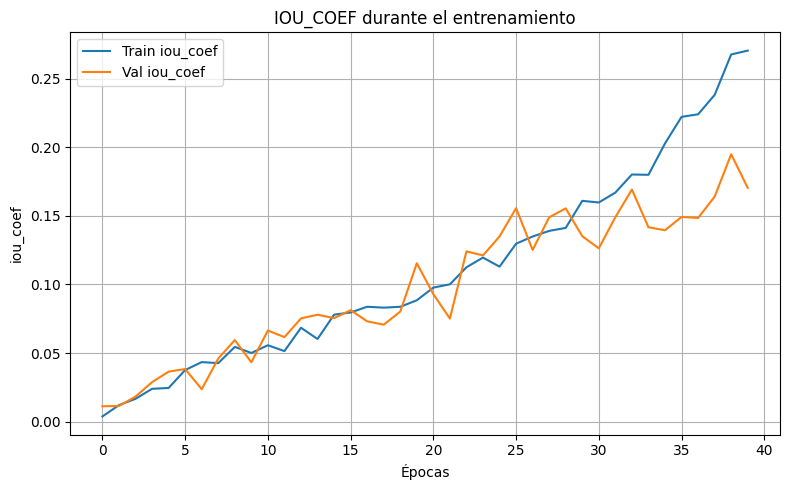

In [ ]:
import matplotlib.pyplot as plt
import pickle

# Cargar el historial guardado
with open(HISTORY_SAVE_PATH, "rb") as f:
    history = pickle.load(f)

# Lista de métricas a graficar
metricas = ['loss', 'dice_coef', 'iou_coef']

# Graficar cada métrica
for metrica in ['loss', 'dice_coef', 'iou_coef']:
    plt.figure(figsize=(8, 5))
    plt.plot(history[metrica], label=f'Train {metrica}')
    plt.plot(history[f'val_{metrica}'], label=f'Val {metrica}')
    plt.title(f'{metrica.upper()} durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel(metrica)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
## CARGA DEL MODELO
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import get_custom_objects

def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

get_custom_objects()['dice_coef'] = dice_coef
get_custom_objects()['iou_coef'] = iou_coef

# Obtener el dataset
#(x_ray_train, y_roi_train), (x_ray_test, y_roi_test) = getMammographyDataset()
# Carga el modelo desde el archivo .keras
model = keras.models.load_model(MODEL_SAVE_PATH)

In [ ]:
# Generar una imagen a partir de una entrada
predictions = model.predict(x_ray_val)

print("Min:", predictions.min(), "Max:", predictions.max(), "Mean:", predictions.mean())


5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
Min: 6.9914676e-38 Max: 0.9945914 Mean: 0.008869582


DICE
Dice score para imagen 142: 1.0000
[[[7.68203987e-04]
  [1.51138775e-05]
  [1.15087607e-06]
  ...
  [2.66651448e-04]
  [4.91925573e-04]
  [4.11219988e-03]]

 [[2.60410088e-05]
  [2.76164940e-07]
  [3.82929777e-08]
  ...
  [1.24363069e-05]
  [5.91745047e-05]
  [4.16710158e-04]]

 [[1.64918686e-06]
  [4.09988310e-09]
  [3.40335787e-10]
  ...
  [8.45893055e-07]
  [6.92632238e-06]
  [5.11135113e-05]]

 ...

 [[1.86027062e-11]
  [2.29732329e-16]
  [3.03728541e-18]
  ...
  [2.31485520e-09]
  [8.20350898e-09]
  [1.95023040e-06]]

 [[1.29321736e-08]
  [5.02132971e-12]
  [9.57114975e-14]
  ...
  [9.63810698e-10]
  [3.45197382e-09]
  [9.17361888e-07]]

 [[3.72177856e-05]
  [9.08446225e-08]
  [6.25654639e-10]
  ...
  [4.00078681e-09]
  [1.61082536e-09]
  [1.38994483e-06]]]


In [ ]:
max_val = np.max(predictions)
threshold = max_val / 2.0
print(f"🔍 Umbral usado: {threshold:.4f}")

# Binarizar las predicciones con un umbral de 0.5
predictions_bin = (predictions > threshold).astype(np.float32)

# Evaluación uno a uno
dice_scores = []
for i in range(len(predictions_bin)):
    score = dice_coef(y_roi_val[i], predictions_bin[i])
    dice_scores.append(score)
    #print(f"Dice score para imagen {i}: {score:.4f}")

# Promedio

dice_scores = np.array(dice_scores)

mean_dice = np.mean(dice_scores)
print(f"\nDice promedio: {mean_dice:.4f}")

max_val = np.max(dice_scores)
min_val = np.min(dice_scores)
print(f"🔺 Valor máximo: {max_val:.4f}")
print(f"🔻 Valor mínimo: {min_val:.4f}")

# Contar cuántos valores son exactamente iguales al máximo y al mínimo
count_max = np.sum(np.isclose(dice_scores, max_val))
count_min = np.sum(np.isclose(dice_scores, min_val))

print(f"🔢 Imágenes con Dice == máximo ({max_val:.4f}): {count_max}")
print(f"🔢 Imágenes con Dice == mínimo ({min_val:.4f}): {count_min}")




🔍 Umbral usado: 0.4973

Dice promedio: 0.3193
🔺 Valor máximo: 0.9441
🔻 Valor mínimo: 0.0000
🔢 Imágenes con Dice == máximo (0.9441): 1
🔢 Imágenes con Dice == mínimo (0.0000): 67


In [ ]:
print(predictions[0])

[[[7.68203987e-04]
  [1.51138775e-05]
  [1.15087607e-06]
  ...
  [2.66651448e-04]
  [4.91925573e-04]
  [4.11219988e-03]]

 [[2.60410088e-05]
  [2.76164940e-07]
  [3.82929777e-08]
  ...
  [1.24363069e-05]
  [5.91745047e-05]
  [4.16710158e-04]]

 [[1.64918686e-06]
  [4.09988310e-09]
  [3.40335787e-10]
  ...
  [8.45893055e-07]
  [6.92632238e-06]
  [5.11135113e-05]]

 ...

 [[1.86027062e-11]
  [2.29732329e-16]
  [3.03728541e-18]
  ...
  [2.31485520e-09]
  [8.20350898e-09]
  [1.95023040e-06]]

 [[1.29321736e-08]
  [5.02132971e-12]
  [9.57114975e-14]
  ...
  [9.63810698e-10]
  [3.45197382e-09]
  [9.17361888e-07]]

 [[3.72177856e-05]
  [9.08446225e-08]
  [6.25654639e-10]
  ...
  [4.00078681e-09]
  [1.61082536e-09]
  [1.38994483e-06]]]


In [ ]:
# Mostrar las primeras 5 imágenes predichas vs etiquetas reales
for i in range(20):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Imagen Entrada")
    plt.imshow(x_ray_val[i].squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Máscara Real")
    plt.imshow(y_roi_val[i].squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Máscara Predicha")
    #plt.imshow(predictions[i].squeeze(), cmap='gray')
    thresholded = (predictions[i] > 0.1).astype(np.uint8)
    plt.imshow(thresholded.squeeze(), cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import matplotlib.pyplot as plt

HEIGHT, WIDTH = 256, 256
n = 10  # Cambia según cuántas comparaciones quieras mostrar

for i in range(n):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    base_img = x_ray_val[i].reshape(HEIGHT, WIDTH)
    real_mask = y_roi_val[i].reshape(HEIGHT, WIDTH)
    pred_mask = predictions[i].reshape(HEIGHT, WIDTH)

    # ROI Real superpuesto
    axs[0].imshow(base_img, cmap='gray')
    axs[0].imshow(real_mask, cmap='Reds', alpha=0.4)
    axs[0].set_title("Mamografía + ROI Real")
    axs[0].axis('off')

    # ROI Predicha superpuesta
    axs[1].imshow(base_img, cmap='gray')
    axs[1].imshow(pred_mask, cmap='Blues', alpha=0.4)
    axs[1].set_title("Mamografía + ROI Predicha")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

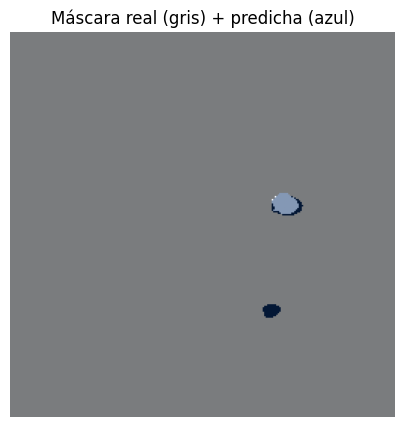

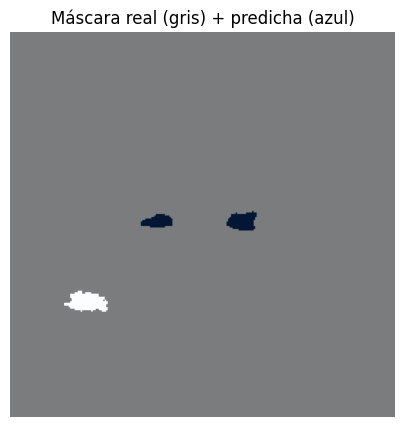

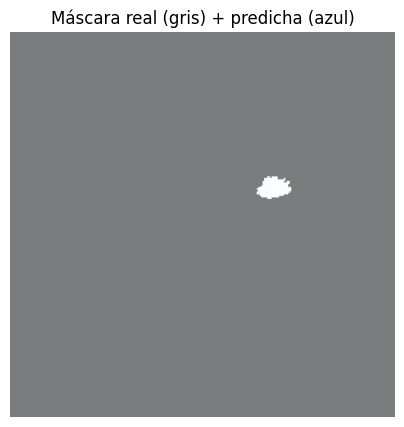

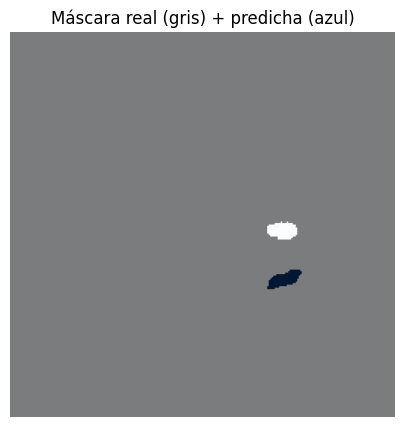

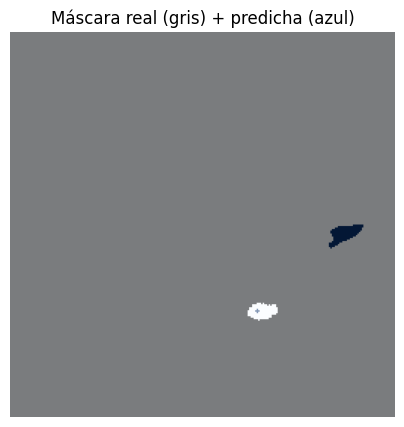

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

HEIGHT, WIDTH = 256, 256
n = 5  # Número de ejemplos a mostrar

for i in range(n):
    fig = plt.figure(figsize=(5, 5))

    real_mask = y_roi_val[i].reshape(HEIGHT, WIDTH)
    pred_mask = predictions[i].reshape(HEIGHT, WIDTH)

    # Binarizar la predicción
    threshold = 0.5
    pred_mask_bin = (pred_mask > threshold).astype(np.uint8)

    # Mostrar la máscara real como fondo (gris)
    plt.imshow(real_mask, cmap='gray', alpha=1.0)

    # Superponer la predicha en azul con transparencia
    plt.imshow(pred_mask_bin, cmap='Blues', alpha=0.5)

    plt.title("Máscara real (gris) + predicha (azul)")
    plt.axis('off')
    plt.show()




In [ ]:
# Evaluación final sobre el conjunto de prueba
test_results = model.evaluate(x_ray_test, y_roi_test, batch_size=20)
print("\n📊 Evaluación final en el conjunto de test:")
for name, value in zip(model.metrics_names, test_results):
    print(f"{name}: {value:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 394ms/step - dice_coef: 0.2603 - iou_coef: 0.1539 - loss: 0.0192

📊 Evaluación final en el conjunto de test:
loss: 0.0186
compile_metrics: 0.3042


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


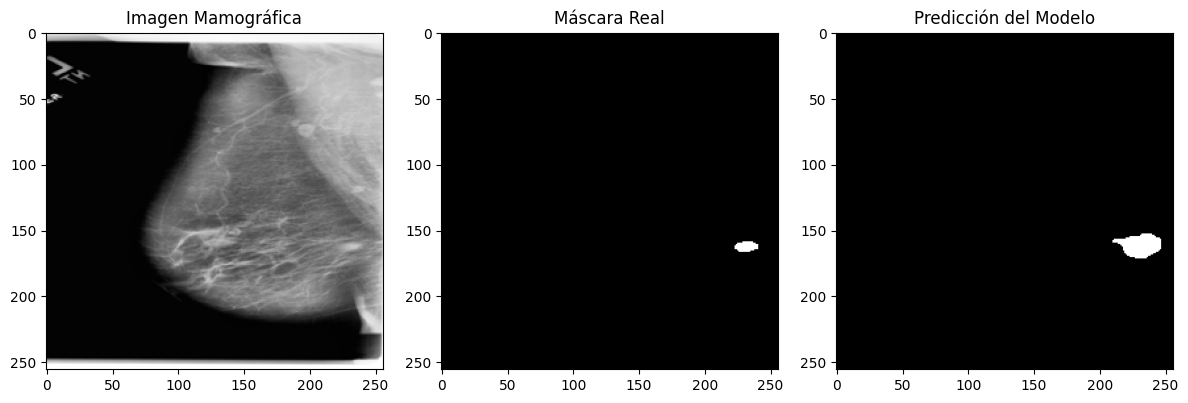

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


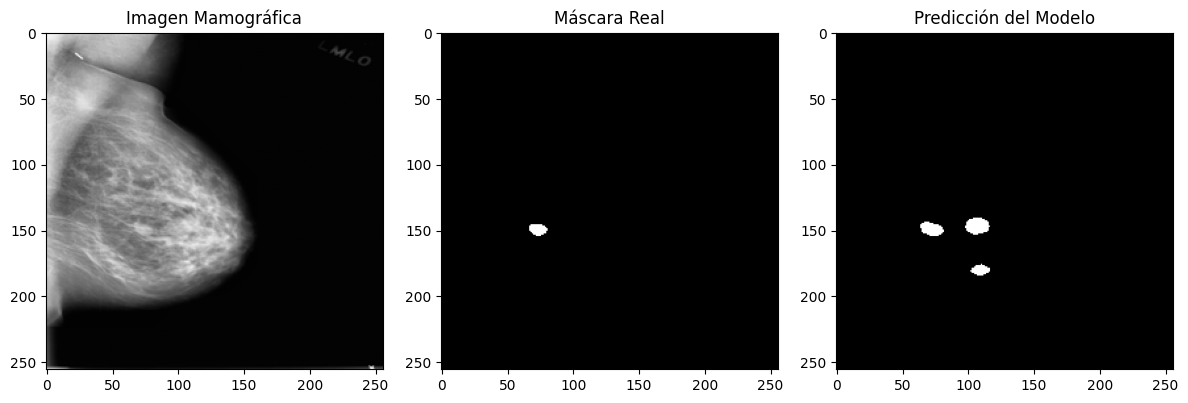

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


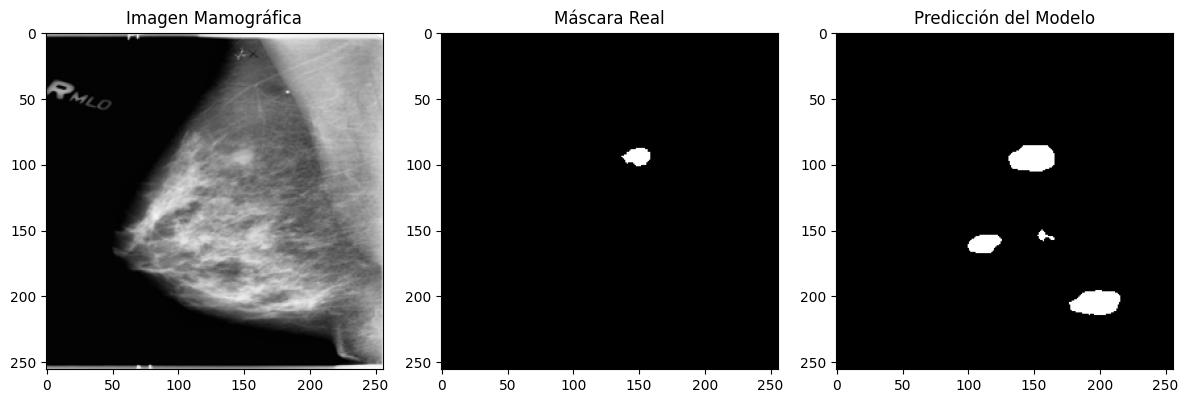

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


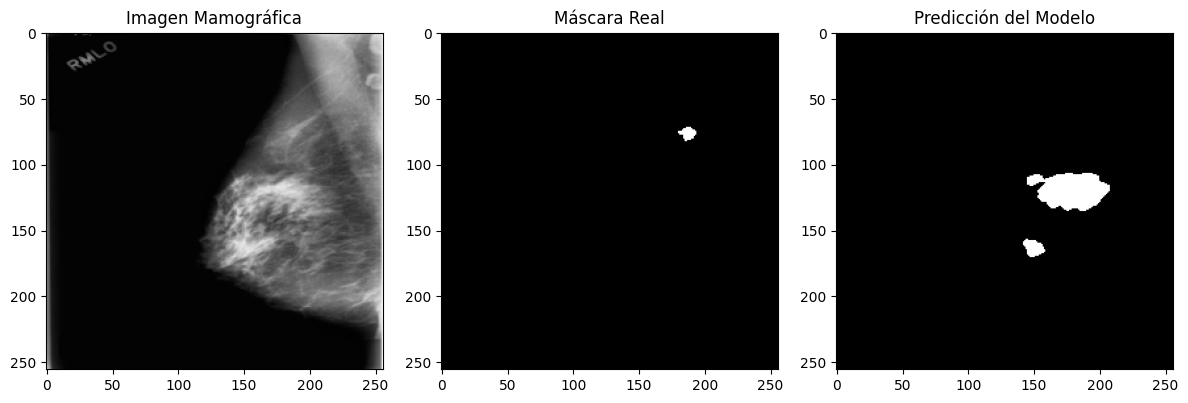

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


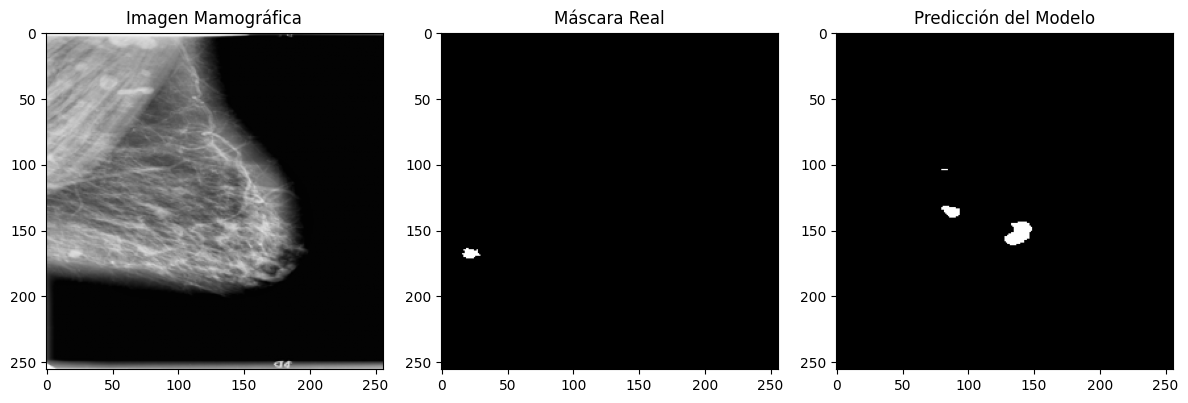

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


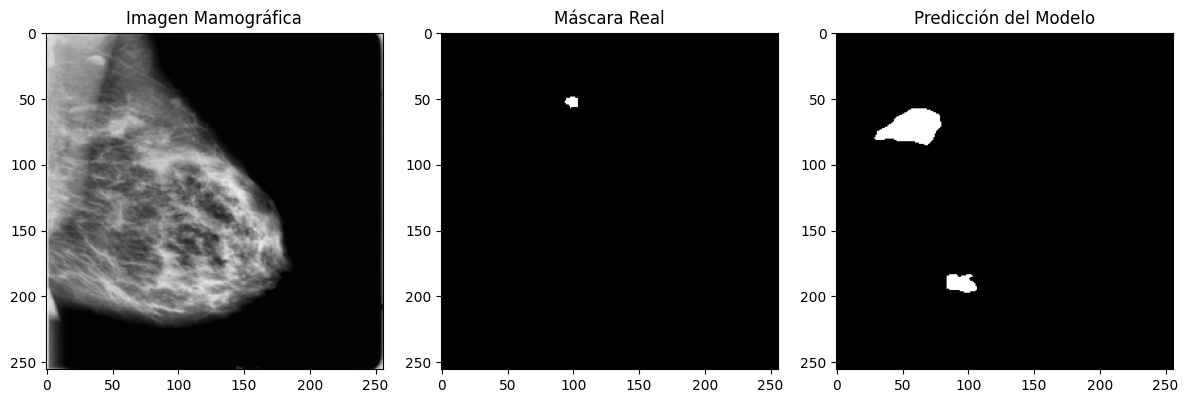

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


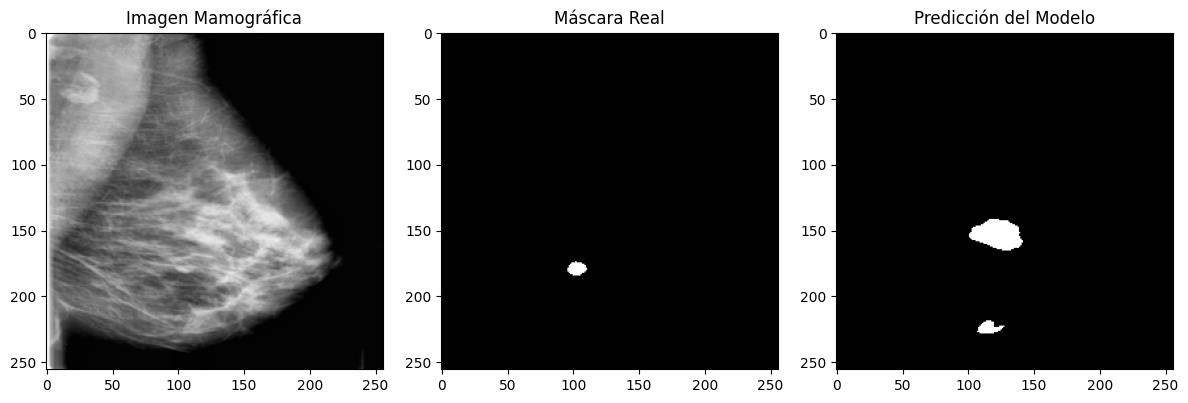

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


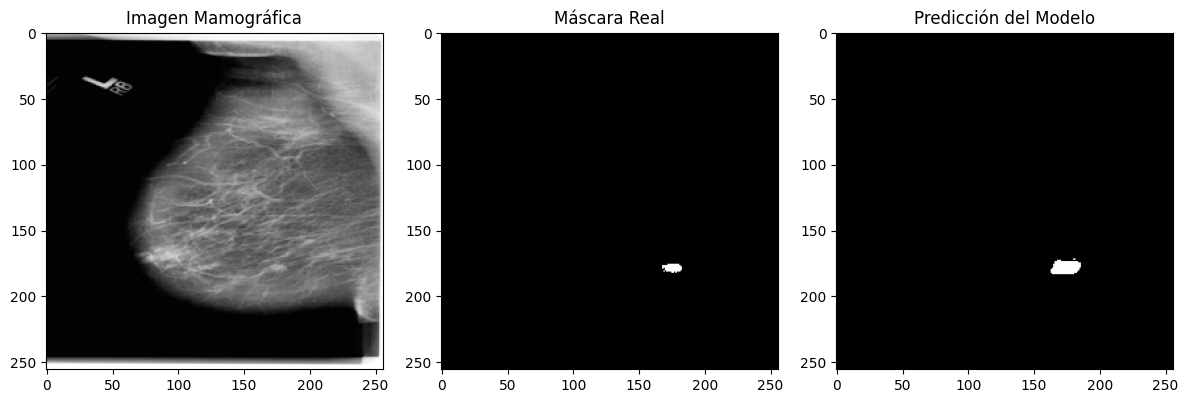

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


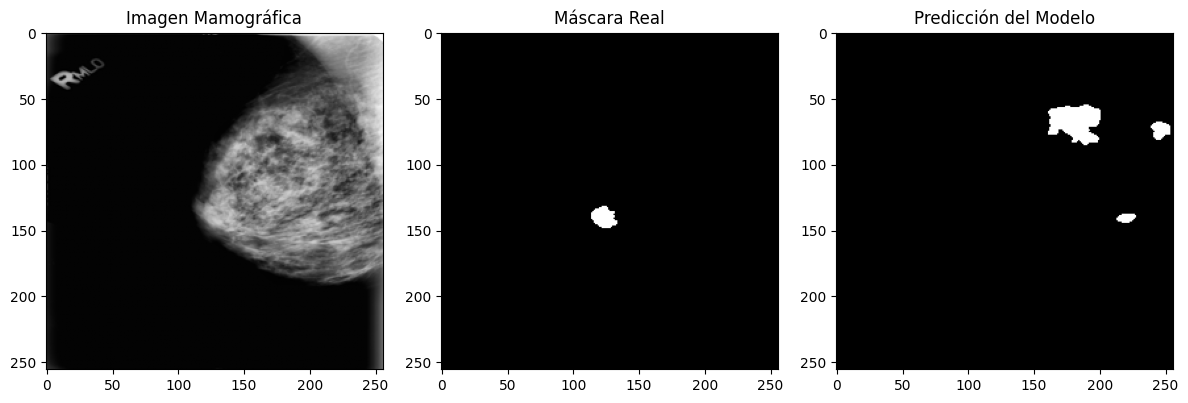

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


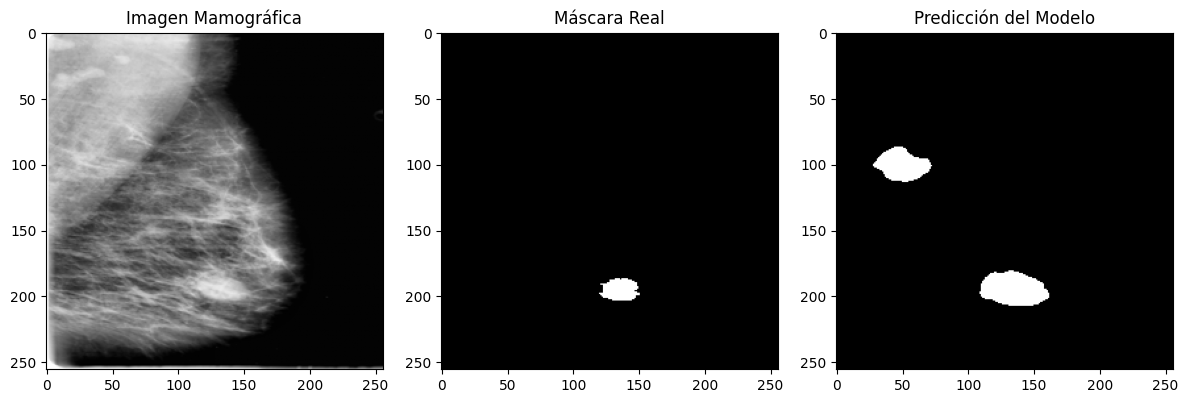

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


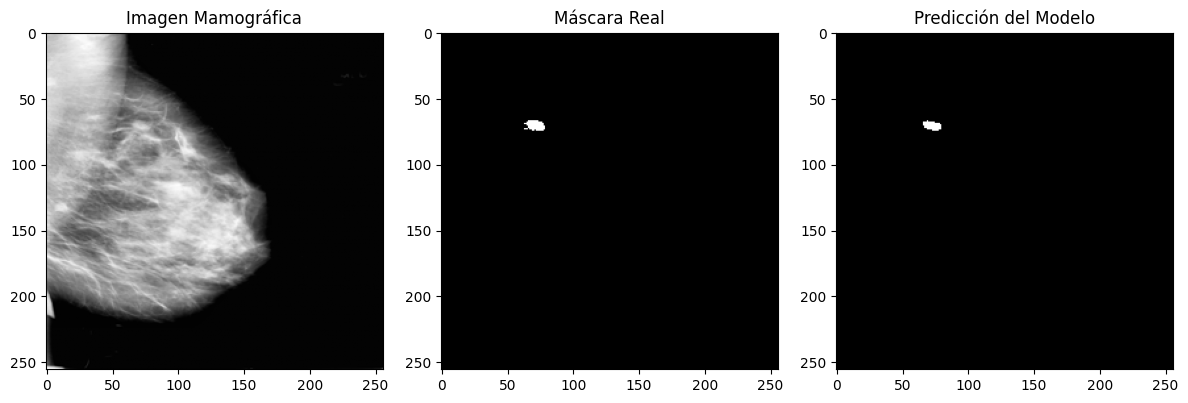

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


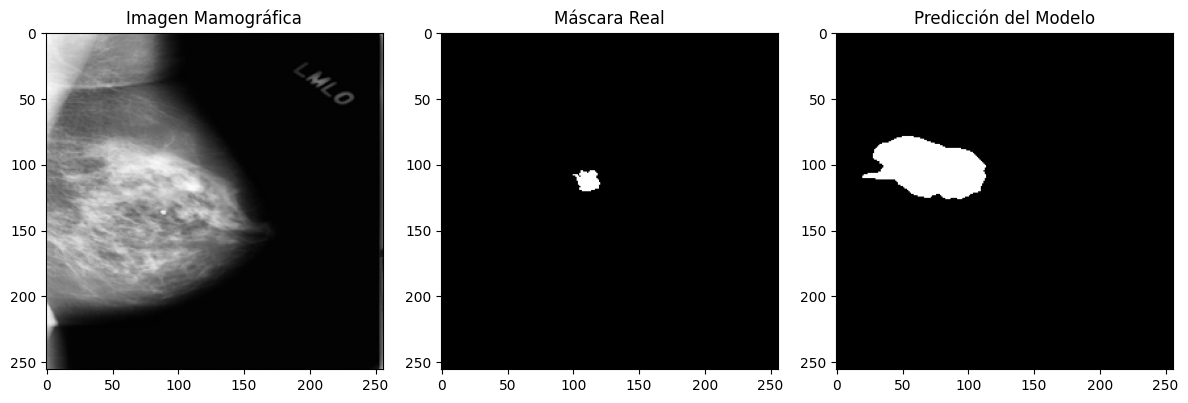

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


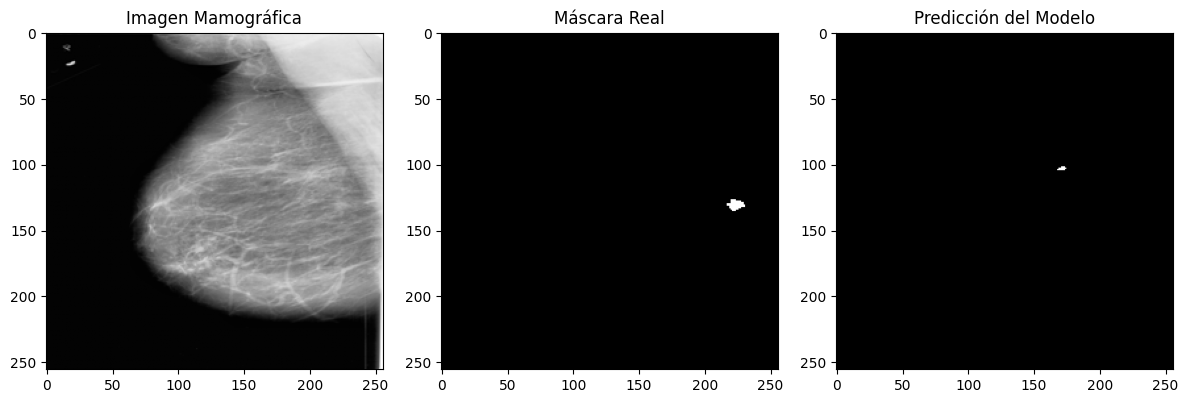

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


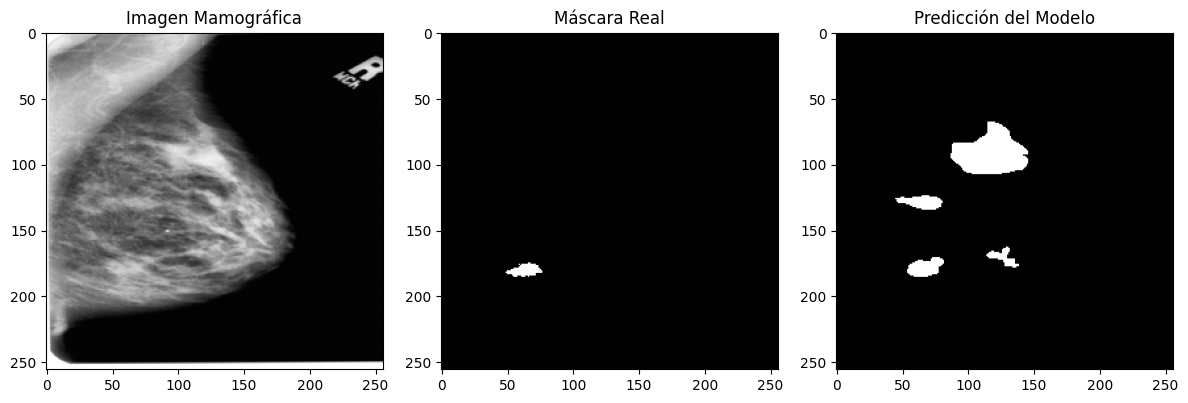

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


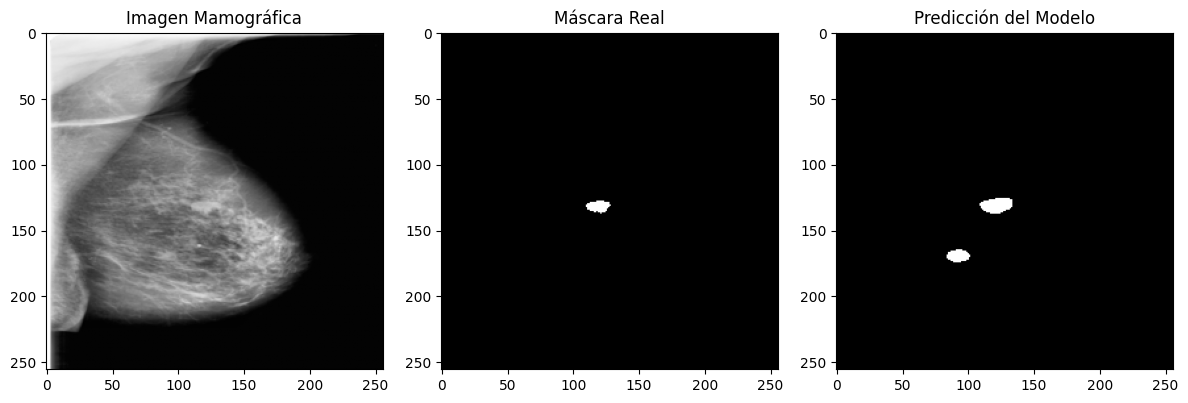

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


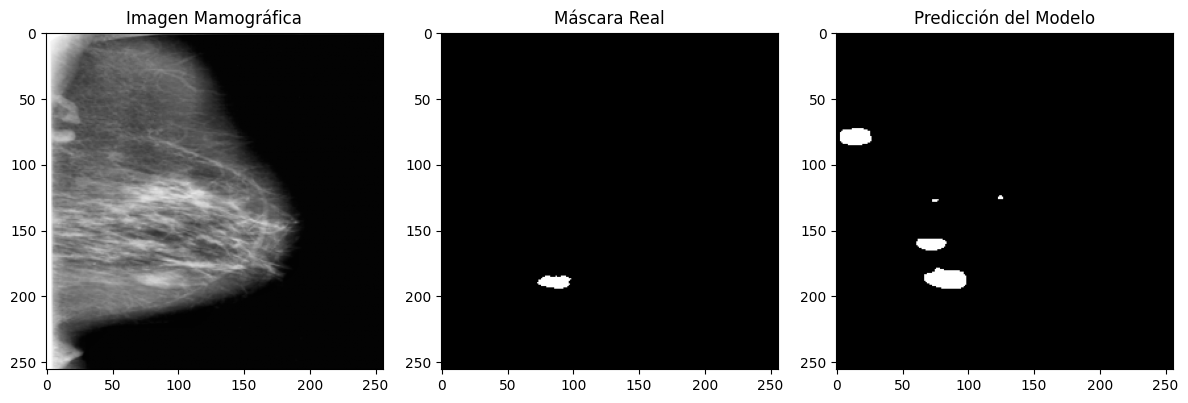

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


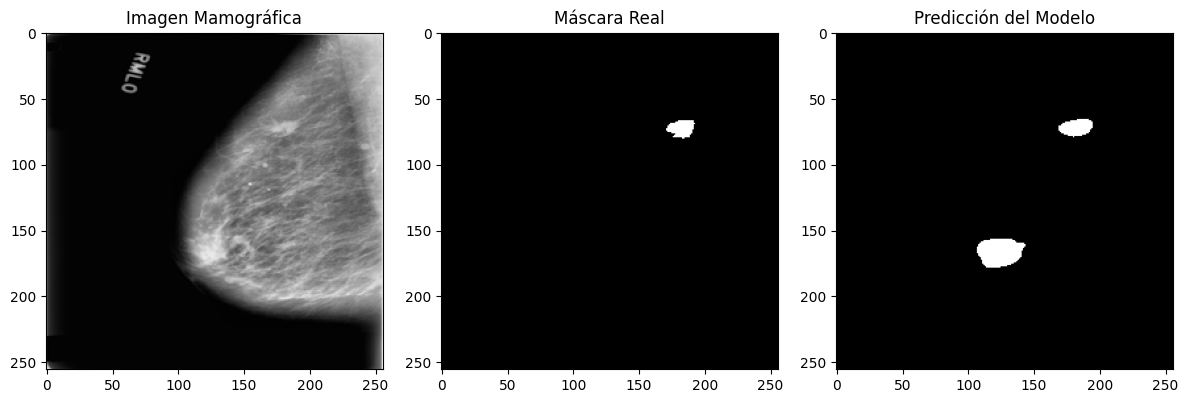

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


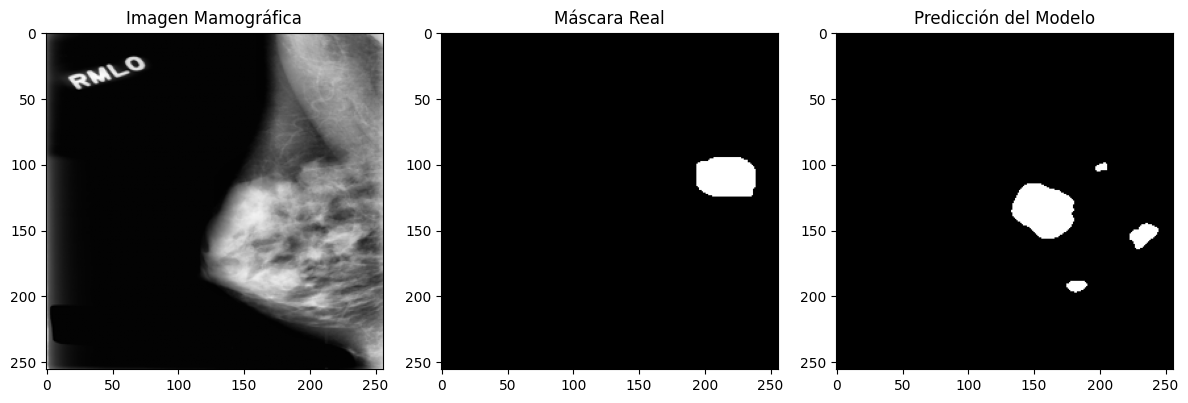

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


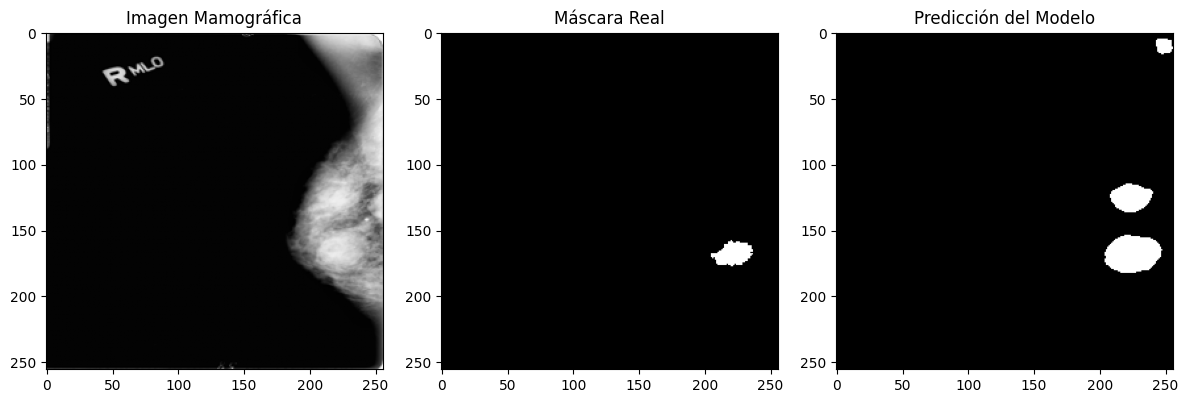

In [ ]:
import matplotlib.pyplot as plt

def show_test_prediction(index=0):
    x = x_ray_test[index]
    y_true = y_roi_test[index]
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred_bin = (y_pred > 0.1).astype(np.uint8)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(x.squeeze(), cmap='gray')
    axs[0].set_title("Imagen Mamográfica")
    axs[1].imshow(y_true.squeeze(), cmap='gray')
    axs[1].set_title("Máscara Real")
    axs[2].imshow(y_pred_bin.squeeze(), cmap='gray')
    axs[2].set_title("Predicción del Modelo")
    plt.tight_layout()
    plt.show()

# Visualizar una predicción del test set
for i in range(1, 20):
    show_test_prediction(i)

